# What will your guests talk about?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import ast

## Load Data

In [3]:
# Select City
country = 'united-states'
city = 'san-francisco'

# Directory
directory = '../data/' + country + '/' + city + '/'

# Load Tags
reviews_topics = pd.read_csv(directory + 'processed/review_topics_final.csv', lineterminator='\n').drop(columns=['Unnamed: 0'])

# Load Listings
listings_df = pd.read_csv(directory + 'listings_full.csv').drop(columns=['Unnamed: 0'])

In [4]:
ID = list(listings_df.iloc[:,:2].columns)

ABOUT_COLS = list(listings_df.iloc[:,3:15].columns)

PICS_COLS = list(listings_df.iloc[:,15:19].columns)

HOST_COLS = list(listings_df.columns[listings_df.columns.str.contains('host')])

NEIGHBORHOOD_COLS = list(listings_df.columns[listings_df.columns.str.contains('neighbourhood')])

LOCATION_COLS = list(listings_df.iloc[:,37:51].columns)

PROPERTY_COLS = list(listings_df.iloc[:,51:60].columns)

PRICE_COLS = list(listings_df.iloc[:,60:67].columns)

NIGHTS_COLS = list(listings_df.columns[listings_df.columns.str.contains('mum')])

AVAILABILITY_COLS = list(listings_df.columns[listings_df.columns.str.contains('availability')])

REVIEW_COLS = list(listings_df.columns[listings_df.columns.str.contains('review')])

In [5]:
listings_df.shape

(7152, 106)

## Clean Data

In [6]:
def clean_listing_full(listing_full_data):
    """Cleans listing_full.csv data"""
    # Input Data
    df = listing_full_data
    
    # String to Datetime
    df.loc[:,'last_scraped'] = pd.to_datetime(df['last_scraped'])
    df.loc[:,'host_since'] = pd.to_datetime(df['host_since'])
    df.loc[:,'first_review'] = pd.to_datetime(df['first_review'])
    df.loc[:,'last_review'] = pd.to_datetime(df['last_review'])
    
    # String to Numeric
    df.loc[:,'host_response_rate'] = pd.to_numeric(df['host_response_rate'].str[:-1]) / 100
    df.loc[:,'price'] = pd.to_numeric(df['price'].str[1:].str.replace(',',''))
    df.loc[:,'security_deposit'] = pd.to_numeric(df['security_deposit'].str[1:].str.replace(',',''))
    df.loc[:,'cleaning_fee'] = pd.to_numeric(df['cleaning_fee'].str[1:].str.replace(',',''))
    df.loc[:,'extra_people'] = pd.to_numeric(df['extra_people'].str[1:].str.replace(',',''))

    return df

## Clean Data

In [7]:
# 
listings_df = listings_df[listings_df['last_scraped'] != 't']
listings_df = clean_listing_full(listings_df)

# Get rid of few blanks in accommodates
listings_df = listings_df[listings_df['accommodates'].notnull()]

# Null is Zero
listings_df.loc[:,'security_deposit'] = listings_df['security_deposit'].fillna(0)
listings_df.loc[:,'cleaning_fee'] = listings_df['cleaning_fee'].fillna(0)

# Get Listing Lifespan: Host_since - Last Scraped
listings_df['listing_lifespan'] = (listings_df['last_scraped']- listings_df['host_since']).map(lambda x: x.days)/365

## Columns

In [286]:
ID = ['listing_id']

TOPIC_COLS = ['Checkin & Communication', 'Cleanliness', 'Value', 'Location',\
              'Accuracy', 'Noise', 'House', 'Host', 'Come Again','Parking']

NUMERIC_COLS = ['accommodates','bathrooms','bedrooms','beds','price','host_response_rate',\
                'host_total_listings_count','review_scores_rating','security_deposit','cleaning_fee',\
                'guests_included','listing_lifespan','number_of_reviews']

TEXT_COLS = ['property_type','room_type','neighbourhood','zipcode','host_response_time']

In [9]:
listings_numeric = listings_df[['id'] + NUMERIC_COLS]
listings_numeric.columns = ID + NUMERIC_COLS

listing_text = pd.get_dummies(listings_df[TEXT_COLS])

listings = listings_numeric.merge(listing_text, right_index=True, left_index=True)

# By Listing Not Normalized

In [10]:
reviews_topics_by_listing = reviews_topics.groupby('listing_id').mean()[TOPIC_COLS].reset_index()
reviews_topics_by_listing['listing_id'] = reviews_topics_by_listing['listing_id'].astype(str)

In [11]:
review_listing_values = reviews_topics_by_listing.merge(listings[['listing_id','review_scores_rating']])

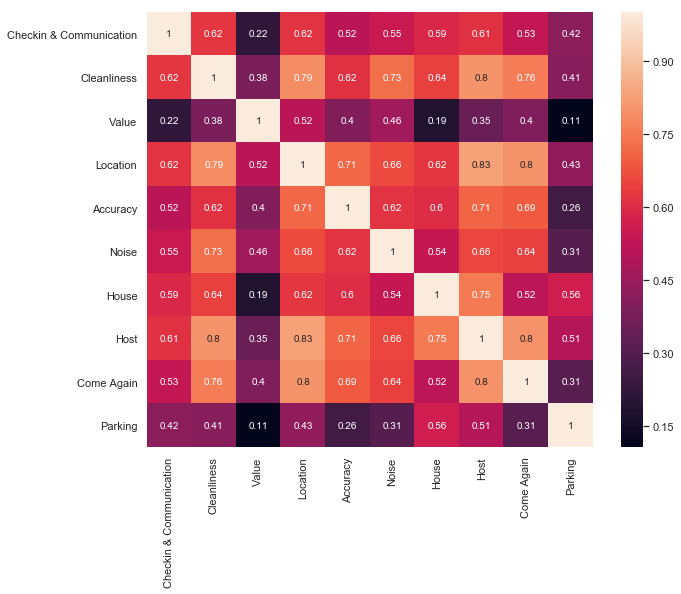

In [12]:
_ = plt.figure(figsize=(10,8))
_ = sns.heatmap(review_listing_values[TOPIC_COLS].corr(), annot=True)

## Normalized Version

In [13]:
from sklearn.preprocessing import normalize

# Normalize
topics_norm = pd.DataFrame(normalize(reviews_topics[TOPIC_COLS]), columns=TOPIC_COLS)

# Important Columns
reviews_norm = reviews_topics.copy()
reviews_norm[TOPIC_COLS] = topics_norm

# Group by Listing
norm_averages_by_listing = reviews_norm.groupby('listing_id').mean()[TOPIC_COLS].reset_index()
norm_averages_by_listing['listing_id'] = norm_averages_by_listing['listing_id'].astype(str)

In [14]:
norm_averages_by_listing.describe()

,Checkin & Communication,Cleanliness,Value,Location,Accuracy,Noise,House,Host,Come Again,Parking
count,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000,5560.000000
mean,0.175656,0.353786,0.114150,0.451408,0.200911,0.166590,0.200156,0.438377,0.346260,0.075007
std,0.073409,0.071056,0.068909,0.071003,0.075363,0.065593,0.080075,0.066985,0.075915,0.055807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.144277,0.324896,0.081650,0.420192,0.166624,0.140272,0.166667,0.405536,0.315704,0.042801
50%,0.171698,0.358631,0.105117,0.452245,0.201199,0.167256,0.202042,0.439907,0.347976,0.068411
75%,0.200607,0.389954,0.135267,0.483151,0.236508,0.194554,0.234615,0.474011,0.378337,0.097143
max,1.000000,0.755929,1.000000,0.866025,0.894427,0.781133,0.852803,0.832050,1.000000,0.722315


In [15]:
#
listing_values = norm_averages_by_listing.merge(listings[['listing_id','review_scores_rating']])

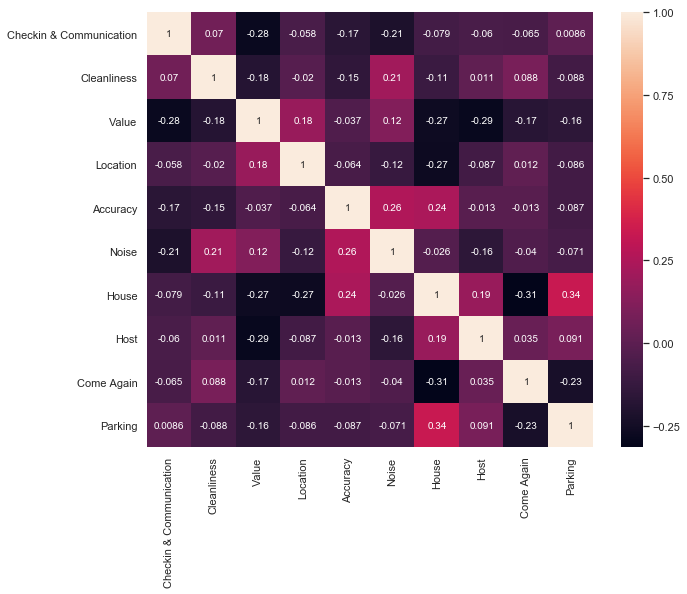

In [16]:
_ = plt.figure(figsize=(10,8))
_ = sns.heatmap(listing_values[TOPIC_COLS].corr(), annot=True)

## Set Threshold

To get rid of noise from some of the less significant features we set a threshold of 0.3.

In [293]:
def above_theshold(data):
    if data > 0.3:
        return data
    else:
        return 0

In [294]:
data = norm_averages_by_listing.copy()

for topic in TOPIC_COLS:
    data[topic] = data[topic].apply(above_theshold)

In [295]:
data.head()

,listing_id,Checkin & Communication,Cleanliness,Value,Location,Accuracy,Noise,House,Host,Come Again,Parking
0,958,0.0,0.328898,0.0,0.476191,0.0,0.0,0.0,0.451187,0.371735,0.0
1,5858,0.0,0.331426,0.0,0.357628,0.0,0.0,0.0,0.533183,0.364524,0.0
2,7918,0.0,0.439090,0.0,0.462244,0.0,0.0,0.0,0.329612,0.000000,0.0
3,8142,0.0,0.539667,0.0,0.352529,0.0,0.0,0.0,0.417356,0.000000,0.0
4,8339,0.0,0.329073,0.0,0.407736,0.0,0.0,0.0,0.489759,0.378745,0.0


# PCA

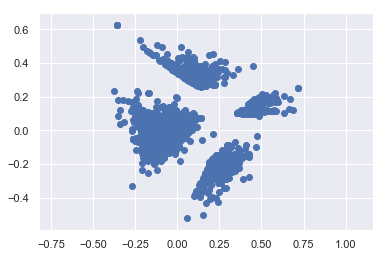

-1.6193263997277165e-16


In [296]:
# Import PCA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# Create PCA instance: model
model = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(data[TOPIC_COLS])

# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]

# Scatter plot xs vs ys
plt.scatter(xs, ys)
plt.axis('equal')
plt.savefig('pca_initial')
plt.show()

# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print(correlation)

# PCA Feature Variance

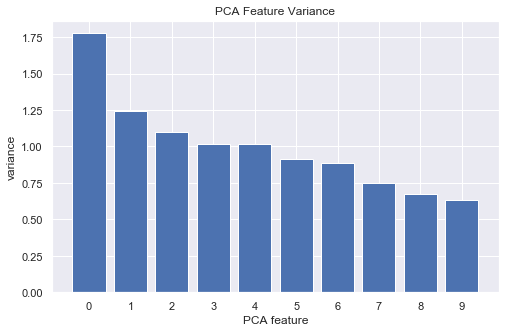

In [297]:
'''Variance of PCA Features'''
# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(data[TOPIC_COLS])

# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize=(8,5))
plt.bar(features, pca.explained_variance_)
plt.title('PCA Feature Variance')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.savefig('PCA_feature_variance_k_means')
plt.show()

## PCA Features

In [298]:
'''Get Top 3 Components PCA'''
# Import PCA
from sklearn.decomposition import PCA

# Create a PCA model with 3 components: pca
pca = PCA(n_components=3)

# Fit the PCA instance to the scaled samples
pca.fit(data[TOPIC_COLS])

# Transform the scaled samples: pca_features
pca_features = pca.transform(data[TOPIC_COLS])

# Print the shape of pca_features
print(pca_features.shape)

(5560, 3)


# KMeans Knee/Elbow

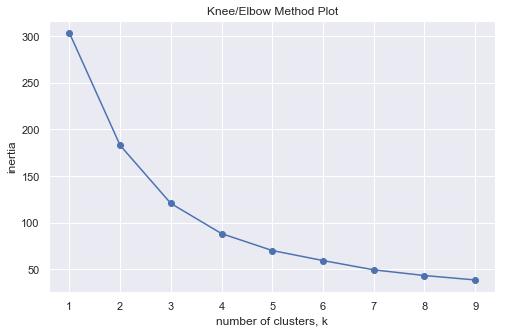

In [299]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_features)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o')
plt.title('Knee/Elbow Method Plot')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('knee_elbow')
plt.show()

# KMeans Cluster

In [300]:
'''KMeans Clustering: Predict Cluster'''
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=4)

# Fit model to points
model.fit(pca_features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [301]:
# Create a KMeans model with 3 clusters: model
model = KMeans(n_clusters=4)

# Use fit_predict to fit model and obtain cluster labels: labels
labels = model.fit_predict(pca_features)
labels

array([0, 0, 2, ..., 0, 0, 0], dtype=int32)

In [336]:
pca = pd.DataFrame()
pca['x'] = xs
pca['y'] = ys
pca['cluster'] = labels

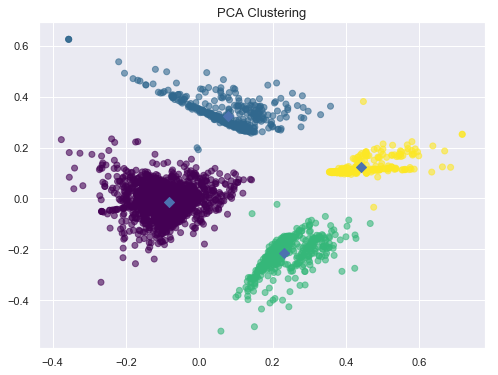

In [302]:
'''Plot Clusters'''
# Assign the columns of new_points: xs and ys
xs = pca_features[:,0]
ys = pca_features[:,1]

# Make a scatter plot of xs and ys, using labels to define the colors
plt.figure(figsize=(8,6))
plt.scatter(xs,ys, c=labels, alpha=0.6, cmap='viridis')

# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y, marker='D', s=50)
plt.title('PCA Clustering', size=13)
plt.savefig('pca_k_means_3')
plt.show()

In [303]:
data['cluster'] = labels

In [304]:
data['cluster'].value_counts()

0    4080
2     686
1     487
3     307
Name: cluster, dtype: int64

# Analysis

In [305]:
# 
data['cluster'] = data['cluster'].astype(str)

# Get Listing Details
listing_details = listings_df[['id'] + TEXT_COLS + NUMERIC_COLS]
listing_details.columns = ['listing_id'] + TEXT_COLS + NUMERIC_COLS

# Merge Listing Details
data = data.merge(listing_details)

In [306]:
data.head()

,listing_id,Checkin & Communication,Cleanliness,Value,Location,Accuracy,Noise,House,Host,Come Again,...,beds,price,host_response_rate,host_total_listings_count,review_scores_rating,security_deposit,cleaning_fee,guests_included,listing_lifespan,number_of_reviews
0,958,0.0,0.328898,0.0,0.476191,0.0,0.0,0.0,0.451187,0.371735,...,2.0,170.0,1.0,1,97.0,100.0,100.0,2.0,10.602740,180.0
1,5858,0.0,0.331426,0.0,0.357628,0.0,0.0,0.0,0.533183,0.364524,...,3.0,235.0,0.8,2,98.0,0.0,100.0,2.0,10.016438,111.0
2,7918,0.0,0.439090,0.0,0.462244,0.0,0.0,0.0,0.329612,0.000000,...,1.0,65.0,1.0,10,85.0,200.0,50.0,1.0,9.723288,17.0
3,8142,0.0,0.539667,0.0,0.352529,0.0,0.0,0.0,0.417356,0.000000,...,1.0,65.0,1.0,10,93.0,200.0,50.0,1.0,9.723288,8.0
4,8339,0.0,0.329073,0.0,0.407736,0.0,0.0,0.0,0.489759,0.378745,...,2.0,785.0,1.0,2,97.0,0.0,225.0,2.0,9.682192,27.0


# Interesting Points

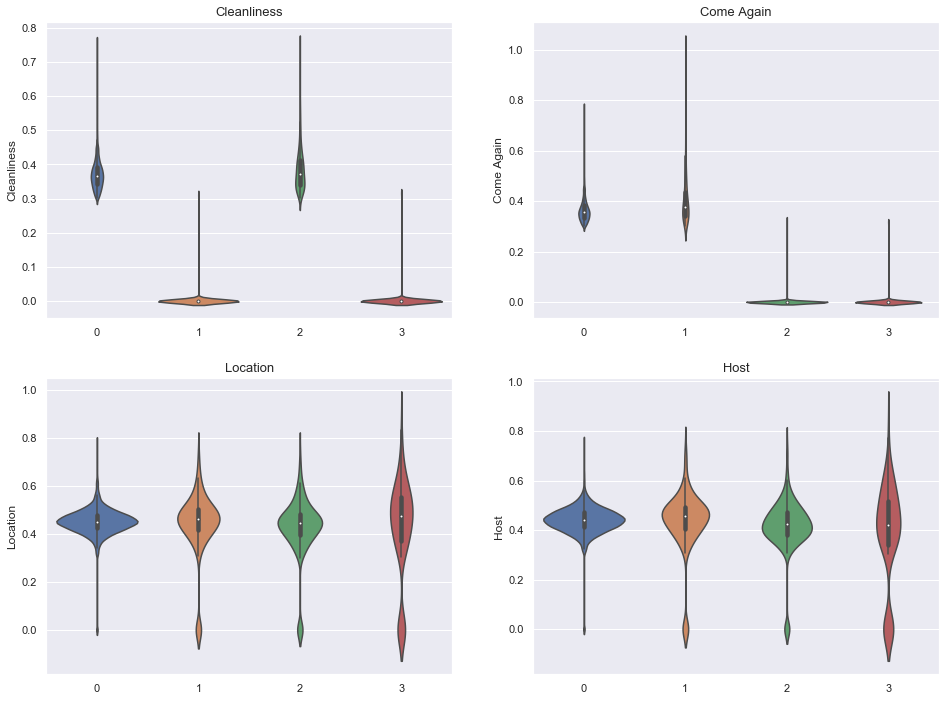

In [307]:
IMP_COLS = ['Cleanliness','Come Again','Location','Host']

#Plot All Distributions
_ = plt.figure(figsize=(16,12))
for x in range(len(IMP_COLS)):
    # Loop all Topic Values and Plot
    plt.subplot(2,2, x+1)
    _ = sns.violinplot(x='cluster', y=IMP_COLS[x], data=data)
    _ = plt.title(IMP_COLS[x], size=13)
    _ = plt.xlabel('')

# Results

## 4 Main Cluster Features:

- #### Cluster 0: High Cleanliness, High Come Again
- #### Cluster 1: Low Cleanliness, High Come Again
- #### Cluster 2: High Cleanliness, Low Come Again
- #### Cluster 3: Low Cleanliness, Low Come Again

# Cluster Analysis

In [308]:
# Clean Listing Data
data['beds'] = data['beds'].astype(float)
data['host_total_listings_count'] = data['host_total_listings_count'].astype(float)

In [317]:
# Separate by Cluster
cluster_0 = data[data['cluster'] == '0']
cluster_1 = data[data['cluster'] == '1']
cluster_2 = data[data['cluster'] == '2']
cluster_3 = data[data['cluster'] == '3']

In [331]:
data['cluster'].value_counts()

0    4079
2     686
1     487
3     307
Name: cluster, dtype: int64

# Comparing Cleanliness Rating

In [312]:
#Bootstrap Sampling
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#Repeat bootstrap x amount of times based on size
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
        
    return bs_replicates

# Plot BS Distributions
def compare_distributions(data1, data2, category, legend):
    """Plot BS Distribution"""
    data1_bs = draw_bs_reps(data1[category].dropna(), np.mean, size=400)
    data2_bs = draw_bs_reps(data2[category].dropna(), np.mean, size=400)
    
    _ = sns.kdeplot(data1_bs, shade=True)
    _ = sns.kdeplot(data2_bs, shade=True)
    _ = plt.legend(legend)
    _ = plt.title(category + ' Distributions')

In [313]:
def compare_distributions(data1, data2, data3, data4, category, legend):
    """Plot BS Distribution"""
    data1_bs = draw_bs_reps(data1[category].dropna(), np.mean, size=400)
    data2_bs = draw_bs_reps(data2[category].dropna(), np.mean, size=400)
    data3_bs = draw_bs_reps(data3[category].dropna(), np.mean, size=400)
    data4_bs = draw_bs_reps(data4[category].dropna(), np.mean, size=400)
    
    _ = sns.kdeplot(data1_bs, shade=True)
    _ = sns.kdeplot(data2_bs, shade=True)
    _ = sns.kdeplot(data3_bs, shade=True)
    _ = sns.kdeplot(data4_bs, shade=True)
    _ = plt.legend(legend)
    _ = plt.title(category + ' Distributions')

## 4 Main Cluster Features:

- #### Cluster 0: High Cleanliness, High Come Again
- #### Cluster 1: Low Cleanliness, High Come Again
- #### Cluster 2: High Cleanliness, Low Come Again
- #### Cluster 3: Low Cleanliness, Low Come Again

In [349]:
#Plot All Distributions
legend = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3']

# Rating

## People talk about Come Again with higher ratings.

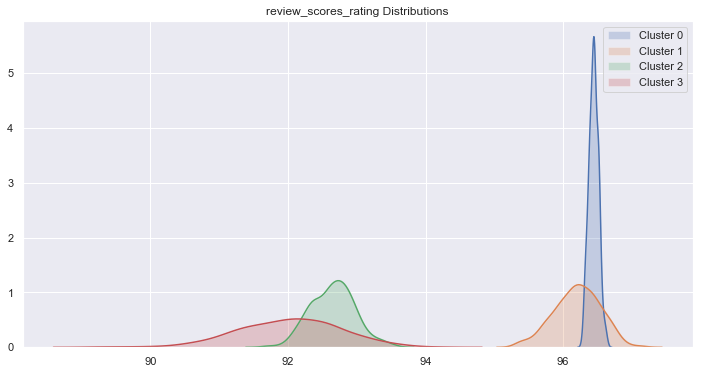

In [330]:
_ = plt.figure(figsize=(12,6))
compare_distributions(cluster_0, cluster_1, cluster_2, cluster_3, 'review_scores_rating',legend)
_ = plt.xlabel('Rating')

# Price

## Higher Cost Listings had Low Cleanliness Mentions but lower cost listings had mentions.

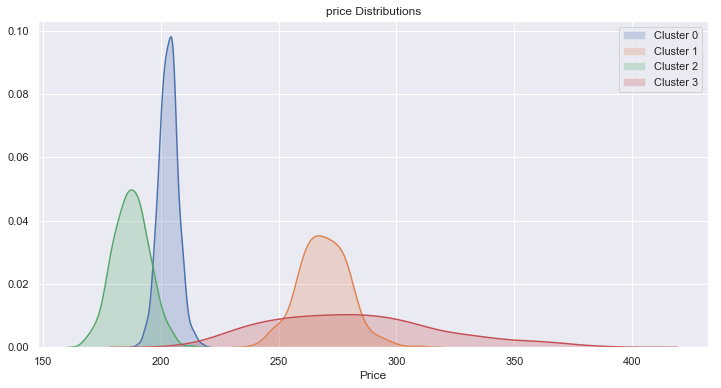

In [343]:
_ = plt.figure(figsize=(12,6))
compare_distributions(cluster_0, cluster_1, cluster_2, cluster_3, 'price',legend)
_ = plt.xlabel('Price')

# Review Count

## Listings that have all high values tended to have more reviews

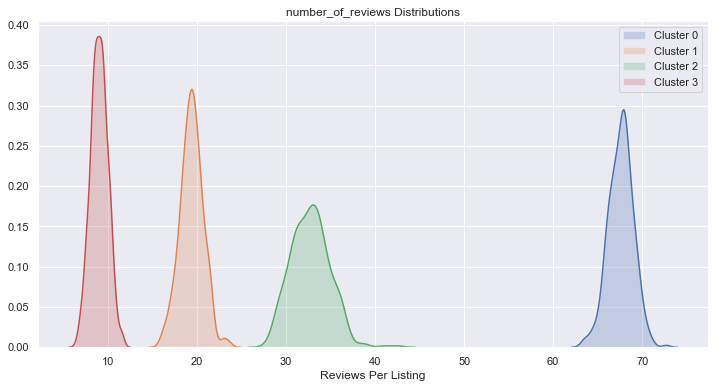

In [345]:
_ = plt.figure(figsize=(12,6))
compare_distributions(cluster_0, cluster_1, cluster_2, cluster_3,'number_of_reviews',legend)
_ = plt.xlabel('Reviews Per Listing')

# Listing Lifespan

## No Real difference in experience

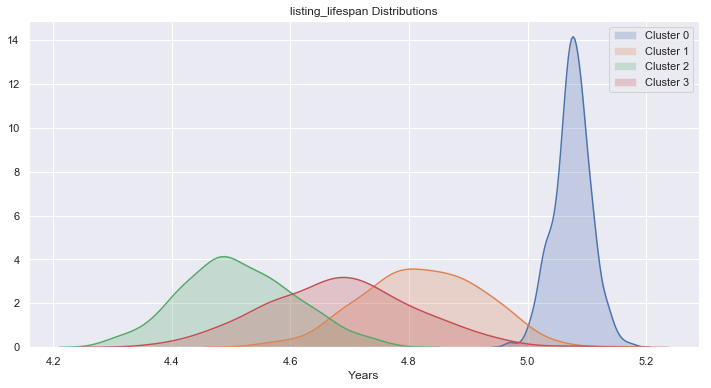

In [342]:
_ = plt.figure(figsize=(12,6))
compare_distributions(cluster_0, cluster_1, cluster_2, cluster_3, 'listing_lifespan',legend)
_ = plt.xlabel('Years')

# All Cluster Comparisons

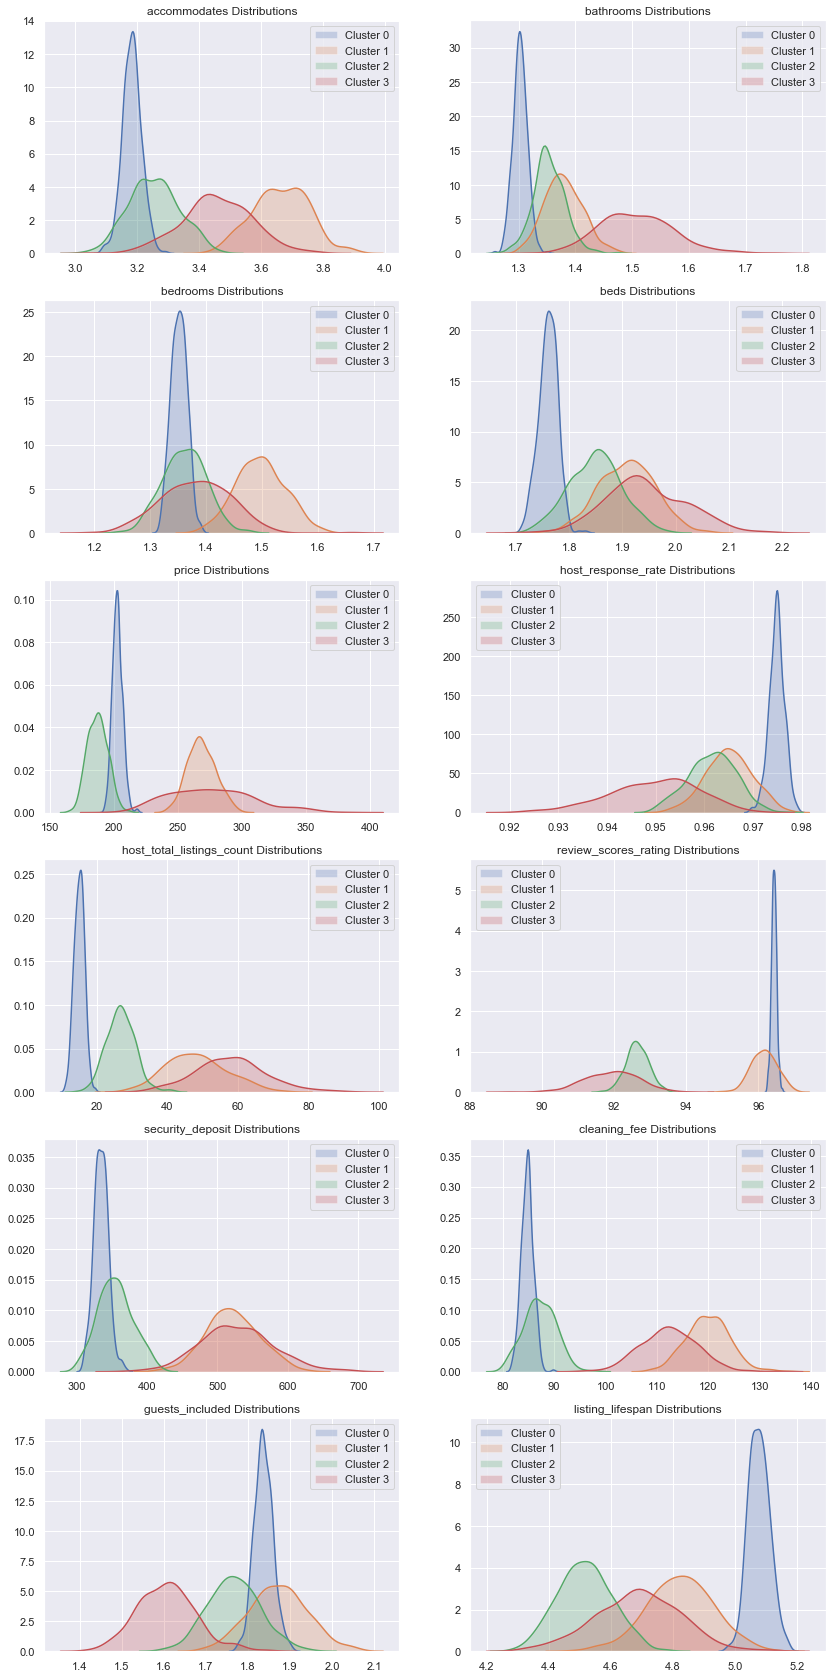

In [350]:
#Plot All Distributions
_ = plt.figure(figsize=(14,30))
for x in range(len(NUMERIC_COLS) - 1):
    # Loop all Topic Values and Plot
    plt.subplot(6,2, x+1)
    compare_distributions(cluster_0, cluster_1, cluster_2, cluster_3, NUMERIC_COLS[x],legend)